# Supervised Learning: Exercise

**Exercise Author:** Bach Nguyen

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from scipy.integrate import odeint

### **1.** Implement an online version of linear regression.

#### **1.1** Old pendulum code

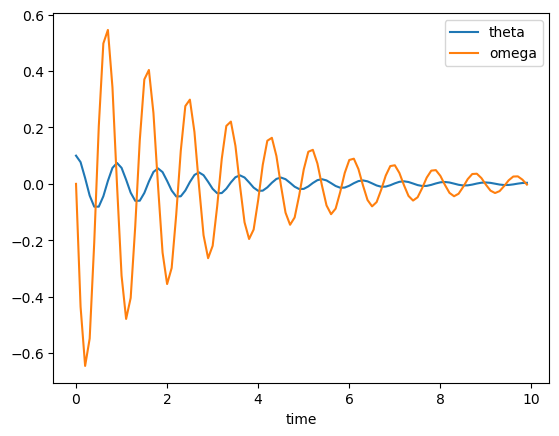

In [2]:
# Dynamics of the arm
l = 0.3  # arm length: m
th = 0.3 # angle: rad
m = 5     # arm mass: kg
mu = 0.1  # damping: Nm/(rad/s)
g = 9.8   # gravity: N/s^2
I = (m*l**2)/3 # inertia for a rod around an end: kg m^2
def arm(x, t):
    """arm dynamics for odeint: x=[th,om]"""
    th, om = np.array(x)  # for readability
    # angular acceleration
    aa = (-m*g*l/2*np.sin(th) - mu*om)/I
    return np.array([om, aa])

# Simulate for 10 sec.
dt = 0.1  # time step
t = np.arange(0, 10, dt)  # time points
X = odeint(arm, [0.1, 0], t)
plt.plot(t, X)
plt.xlabel("time")
plt.legend(("theta","omega"))
plt.show()

In [3]:
# Implemetation of the original batch solver
# Acceleration by differentiation
Y = (X[1:,1] - X[:-1,1])/dt  # temporal difference
X = X[:-1,:]    # omit the last point
N, D = X.shape  # data count and dimension
# add observation noise
sig = 1.0   # noise size
Y = Y + sig*np.random.randn(N)

# Prepare data matrix
X1 = np.c_[np.ones(N), X] #  add a column of 1's
# Compute the weights: W = (X^T X)^(-1) X^T Y
w = np.linalg.inv(X1.T@X1) @ X1.T@Y
#w = np.linalg.solve(X1.T@X1, X1.T@Y)
print("w =", w)
print([0, -m*g*l/2/I, -mu/I])  # analytic values

mse = np.sum((X1@w - Y)**2)/N  # mean squared error

w = [-1.84809482e-02 -4.25820412e+01 -3.05413338e+00]
[0, -49.0, -0.6666666666666667]


#### **1.2** Online linear regression with SGD

In [4]:
class OnlineLinearRegression:
    """Online Linear Regression using Stochastic Gradient Descent"""
    
    def __init__(self, D=2, alpha=0.01):
        """Initialize with D-dimensional input and learning rate alpha"""
        self.w = np.zeros(D+1)  # weights including bias (w0)
        self.alpha = alpha      # learning rate
        self.errors = []        # track error history
        
    def predict(self, x):
        """Predict output for input x"""
        # Add bias term (x0 = 1)
        x_aug = np.r_[1, x] if x.ndim == 1 else np.c_[np.ones(x.shape[0]), x]
        return self.w @ x_aug.T if x.ndim > 1 else self.w @ x_aug
    
    def update(self, x, y_target):
        """Update weights using one data point (x, y_target)"""
        x_aug = np.r_[1, x]                     # Add bias term
        y_pred = self.w @ x_aug                 # Predict current output
        error = y_target - y_pred               # Compute error
        self.w += self.alpha * error * x_aug    # SGD update: w = w + alpha * error * x
        self.errors.append(error**2)            # Store squared error for tracking
    
        return error
    
    def train_online(self, X, Y, epochs=1, shuffle=True):
        """Train on dataset for multiple epochs"""
        N = len(X)
        
        for epoch in range(epochs):
            # Shuffle data order for each epoch
            if shuffle:
                indices = np.random.permutation(N)
            else:
                indices = np.arange(N)
                
            epoch_errors = []
            for i in indices:
                error = self.update(X[i], Y[i])
                epoch_errors.append(error**2)
                
            if (epoch + 1) % 10 == 0 or epoch == 0:
                mse = np.mean(epoch_errors)
                print(f"Epoch {epoch+1}: MSE = {mse:.4f}, weights = {self.w}")

In [5]:
# Test online linear regression
print("Testing Online Linear Regression:")
print("="*40)

# Create and train online linear regression
online_lr = OnlineLinearRegression(D=2, alpha=0.1)  # Lower learning rate for stability

# Train for multiple epochs
online_lr.train_online(X, Y, epochs=50, shuffle=True)

print("\nFinal weights from online learning:", online_lr.w)
print("Batch learning weights for comparison:", w)
print("Analytical values:", [0, -m*g*l/2/I, -mu/I])

Testing Online Linear Regression:
Epoch 1: MSE = 3.1938, weights = [-0.14287476 -0.33048609 -0.82393175]
Epoch 10: MSE = 2.6808, weights = [-0.0569505  -3.2600141  -2.34332759]
Epoch 20: MSE = 2.5897, weights = [-0.14056511 -6.31396644 -2.51220353]
Epoch 30: MSE = 2.3755, weights = [-0.25602475 -9.10647117 -2.71120612]
Epoch 40: MSE = 2.2692, weights = [ -0.22848858 -11.75134343  -2.72287262]
Epoch 50: MSE = 2.0899, weights = [  0.38639892 -14.15771052  -2.63937279]

Final weights from online learning: [  0.38639892 -14.15771052  -2.63937279]
Batch learning weights for comparison: [-1.84809482e-02 -4.25820412e+01 -3.05413338e+00]
Analytical values: [0, -49.0, -0.6666666666666667]


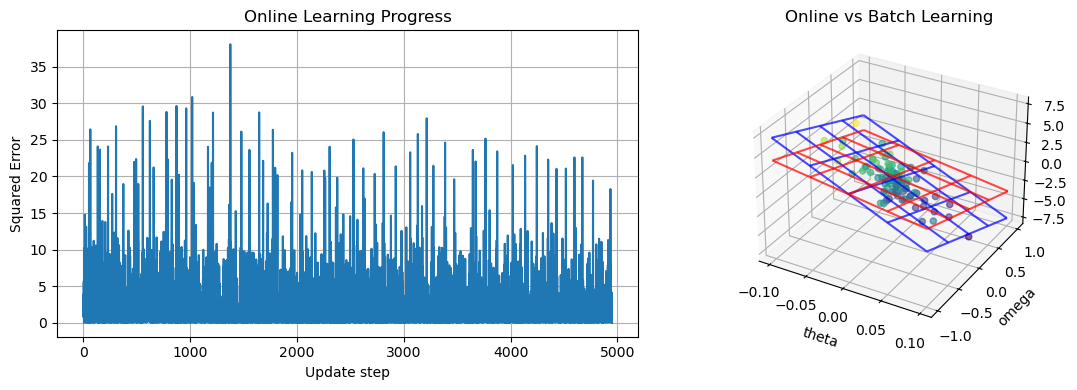


Final MSE - Online: 2.1548, Batch: 1.3267


In [6]:
# Plot learning progress
plt.figure(figsize=(12, 4))

# Plot 1: Error evolution during training
plt.subplot(1, 2, 1)
plt.plot(online_lr.errors)
plt.xlabel('Update step')
plt.ylabel('Squared Error')
plt.title('Online Learning Progress')
plt.grid(True)

# Plot 2: Compare regression surfaces
ax = plt.subplot(1, 2, 2, projection='3d')

# Online learning surface
X2, Y2 = np.meshgrid(np.linspace(-0.1,0.1,5),np.linspace(-1,1,5))
Z2_online = online_lr.w[0] + online_lr.w[1]*X2 + online_lr.w[2]*Y2
ax.plot_wireframe(X2, Y2, Z2_online, color='red', alpha=0.7, label='Online')

# Batch learning surface (original)
Z2_batch = w[0] + w[1]*X2 + w[2]*Y2
ax.plot_wireframe(X2, Y2, Z2_batch, color='blue', alpha=0.7, label='Batch')

# Show the data
ax.scatter(X[:,0], X[:,1], Y, c=Y, alpha=0.6)
ax.set_xlabel("theta")
ax.set_ylabel("omega")
ax.set_title('Online vs Batch Learning')

plt.tight_layout()
plt.show()

# Calculate final MSE for online learning
y_pred_online = online_lr.predict(X)
mse_online = np.mean((y_pred_online - Y)**2)
print(f"\nFinal MSE - Online: {mse_online:.4f}, Batch: {mse:.4f}")

#### **1.3** Online learning demonstration: single epoch

Visualize how the online linear regression adapts step by step during a single training epoch, showing the evolution of weights and predictions as each data point is processed.

In [7]:
# Online learning demonstration - single epoch
print("Online Learning Demonstration: Single Training Epoch")
print("="*55)

# Create a fresh online linear regression model
demo_lr = OnlineLinearRegression(D=2, alpha=0.1)

# Select a subset of data points for clear visualization (first 12 points)
n_demo = min(12, len(X))
X_demo = X[:n_demo]
Y_demo = Y[:n_demo]

# Store weight evolution
weight_history = [demo_lr.w.copy()]  # Initial weights
error_history = []
prediction_history = []

print(f"Initial weights: {demo_lr.w}")
print(f"Processing {n_demo} data points...\n")

# Process each data point and track evolution
for i in range(n_demo):
    # Make prediction with current weights
    y_pred = demo_lr.predict(X_demo[i])
    prediction_history.append(y_pred)
    
    # Update weights with current data point
    error = demo_lr.update(X_demo[i], Y_demo[i])
    error_history.append(error)
    
    # Store updated weights
    weight_history.append(demo_lr.w.copy())
    
    print(f"Step {i+1:2d}: x=[{X_demo[i,0]:6.3f}, {X_demo[i,1]:6.3f}], y_true={Y_demo[i]:7.3f}, "
          f"y_pred={y_pred:7.3f}, error={error:7.3f}, w={demo_lr.w}")

print(f"\nFinal weights: {demo_lr.w}")
print(f"Weight change: {demo_lr.w - weight_history[0]}")

Online Learning Demonstration: Single Training Epoch
Initial weights: [0. 0. 0.]
Processing 12 data points...

Step  1: x=[ 0.100,  0.000], y_true= -4.631, y_pred=  0.000, error= -4.631, w=[-0.46309643 -0.04630964  0.        ]
Step  2: x=[ 0.077, -0.436], y_true= -1.008, y_pred= -0.467, error= -0.542, w=[-0.51725833 -0.05048162  0.0235975 ]
Step  3: x=[ 0.021, -0.646], y_true=  0.680, y_pred= -0.534, error=  1.213, w=[-0.3959509  -0.04799159 -0.05470802]
Step  4: x=[-0.042, -0.548], y_true=  3.846, y_pred= -0.364, error=  4.210, w=[ 0.02502732 -0.06553226 -0.28550936]
Step  5: x=[-0.081, -0.208], y_true=  3.796, y_pred=  0.090, error=  3.706, w=[ 0.39561561 -0.09551287 -0.36260174]
Step  6: x=[-0.081,  0.205], y_true=  1.843, y_pred=  0.329, error=  1.514, w=[ 0.54703399 -0.10775233 -0.33161089]
Step  7: x=[-0.044,  0.498], y_true=  1.140, y_pred=  0.387, error=  0.753, w=[ 0.62236528 -0.11106901 -0.29410634]
Step  8: x=[ 0.010,  0.546], y_true= -1.218, y_pred=  0.461, error= -1.678, w


Regression Surface Evolution:


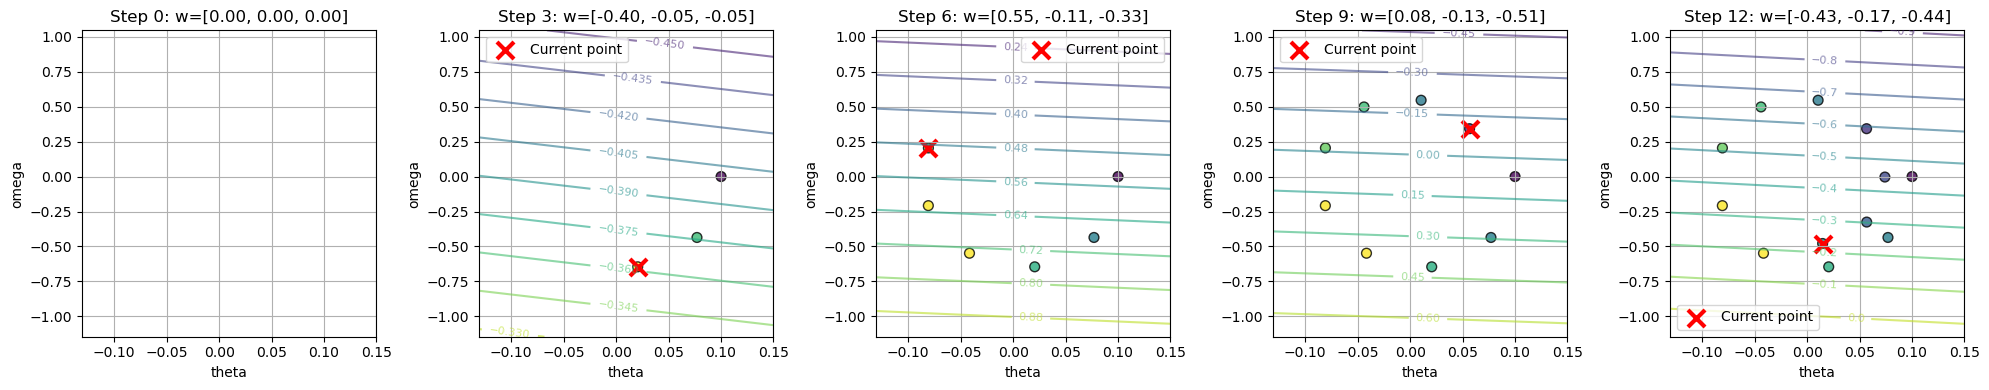

In [8]:
# Show evolution of regression surface during online learning
print("\nRegression Surface Evolution:")
print("="*35)

# Create a grid for visualization
theta_range = np.linspace(X[:,0].min()-0.05, X[:,0].max()+0.05, 20)
omega_range = np.linspace(X[:,1].min()-0.5, X[:,1].max()+0.5, 20)
Theta_grid, Omega_grid = np.meshgrid(theta_range, omega_range)
X_grid = np.c_[Theta_grid.ravel(), Omega_grid.ravel()]

# Show regression surface at key steps
steps_to_show = [0, 3, 6, 9, 12]  # Initial + 4 intermediate steps
fig, axes = plt.subplots(1, len(steps_to_show), figsize=(20, 4))

for idx, step in enumerate(steps_to_show):
    ax = axes[idx]
    
    # Use weights from this step
    w_step = weight_history[step]
    
    # Compute predictions on grid
    X_grid_aug = np.c_[np.ones(len(X_grid)), X_grid]
    Z_pred = X_grid_aug @ w_step
    Z_pred = Z_pred.reshape(Theta_grid.shape)
    
    # Plot surface
    contour = ax.contour(Theta_grid, Omega_grid, Z_pred, levels=10, alpha=0.6)
    ax.clabel(contour, inline=True, fontsize=8)
    
    # Plot data points processed so far
    if step > 0:
        ax.scatter(X_demo[:step, 0], X_demo[:step, 1], c=Y_demo[:step], 
                  s=50, alpha=0.8, cmap='viridis', edgecolors='black', linewidth=1)
        
        # Highlight the current data point
        if step <= len(X_demo):
            ax.scatter(X_demo[step-1, 0], X_demo[step-1, 1], 
                      c='red', s=150, marker='x', linewidth=3, label=f'Current point')
    
    ax.set_xlabel('theta')
    ax.set_ylabel('omega')
    ax.set_title(f'Step {step}: w=[{w_step[0]:.2f}, {w_step[1]:.2f}, {w_step[2]:.2f}]')
    ax.grid(True)
    if step > 0 and step <= len(X_demo):
        ax.legend()

plt.tight_layout()
plt.show()

In [9]:
# Compare final online result with batch learning
print("\nComparison with Batch Learning:")
print("="*35)

# Batch learning (least squares solution)
X_aug = np.c_[np.ones(len(X_demo)), X_demo]
w_batch = np.linalg.solve(X_aug.T @ X_aug, X_aug.T @ Y_demo)

# Predictions
y_pred_online_final = demo_lr.predict(X_demo)
y_pred_batch = X_aug @ w_batch

# Calculate MSE
mse_online = np.mean((y_pred_online_final - Y_demo)**2)
mse_batch = np.mean((y_pred_batch - Y_demo)**2)

print(f"Online Learning (single epoch):")
print(f"  Final weights: [{demo_lr.w[0]:.4f}, {demo_lr.w[1]:.4f}, {demo_lr.w[2]:.4f}]")
print(f"  MSE: {mse_online:.4f}")

print(f"\nBatch Learning (analytical solution):")
print(f"  Weights: [{w_batch[0]:.4f}, {w_batch[1]:.4f}, {w_batch[2]:.4f}]")
print(f"  MSE: {mse_batch:.4f}")

print(f"\nWeight differences: [{abs(demo_lr.w[0]-w_batch[0]):.4f}, {abs(demo_lr.w[1]-w_batch[1]):.4f}, {abs(demo_lr.w[2]-w_batch[2]):.4f}]")


Comparison with Batch Learning:
Online Learning (single epoch):
  Final weights: [-0.4344, -0.1677, -0.4364]
  MSE: 6.5227

Batch Learning (analytical solution):
  Weights: [-0.0195, -40.7132, -2.4128]
  MSE: 0.4203

Weight differences: [0.4150, 40.5454, 1.9765]


### **2.** Implement linear regression using Gaussian basis fuctions. 
Test that with, for example, the nonlinear pendulum simulation with a large amplitude.

#### **2.1** Gaussian basis regression

In [10]:
class GaussianBasisRegression:
    """Linear Regression using Gaussian Basis Functions"""
    
    def __init__(self, centers, sigma=1.0):
        """ Initialize Gaussian basis regression """
        self.centers = np.array(centers)
        self.sigma = sigma
        self.M = len(centers)  # number of basis functions
        self.w = None  # weights to be learned
        
    def gaussian_basis(self, X):
        """ Compute Gaussian basis functions for input X """
        N = X.shape[0]
        Phi = np.zeros((N, self.M + 1))
        
        # Bias term (constant basis function)
        Phi[:, 0] = 1.0
        
        # Gaussian basis functions
        for i, center in enumerate(self.centers):
            dist_sq = np.sum((X - center)**2, axis=1)               # Compute squared distance from each data point to center
            Phi[:, i+1] = np.exp(-dist_sq / (2 * self.sigma**2))    # Gaussian basis function
            
        return Phi
    
    def fit(self, X, Y):
        """ Fit the model using least squares """
        Phi = self.gaussian_basis(X)
        # Solve normal equations: w = (Phi^T Phi)^(-1) Phi^T Y
        self.w = np.linalg.solve(Phi.T @ Phi, Phi.T @ Y)
        return self
    
    def predict(self, X):
        """ Make predictions for input X """
        if self.w is None:
            raise ValueError("Model not fitted yet. Call fit() first.")
        
        Phi = self.gaussian_basis(X)
        return Phi @ self.w
    
    def score(self, X, Y):
        """ Compute mean squared error """
        Y_pred = self.predict(X)
        return np.mean((Y - Y_pred)**2)

#### **2.2** Generate pendulum data

Generating nonlinear pendulum data with large amplitude...
Generated 299 data points with theta range: [-1.24, 1.50] rad
Omega range: [-8.82, 7.54] rad/s


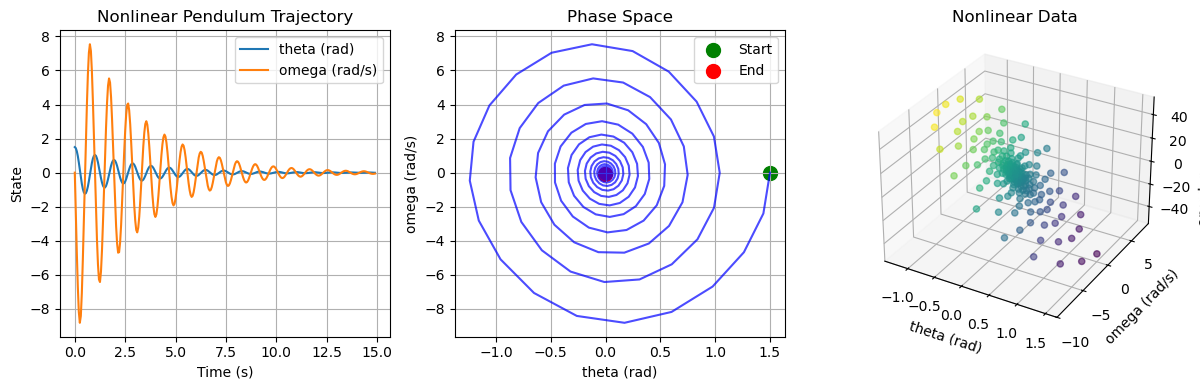

In [11]:
# Generate nonlinear pendulum data with large amplitude
print("Generating nonlinear pendulum data with large amplitude...")

# Simulate pendulum with large initial angle for nonlinear behavior
dt_nl = 0.05  # smaller time step for accuracy
t_nl = np.arange(0, 15, dt_nl)  # longer simulation
X_nl = odeint(arm, [1.5, 0], t_nl)  # Large initial angle (1.5 rad ≈ 86 degrees)

# Compute angular acceleration by differentiation
Y_nl = (X_nl[1:,1] - X_nl[:-1,1])/dt_nl
X_nl = X_nl[:-1,:]
N_nl, D_nl = X_nl.shape

# Add observation noise
sig_nl = 0.5
Y_nl = Y_nl + sig_nl * np.random.randn(N_nl)

print(f"Generated {N_nl} data points with theta range: [{X_nl[:,0].min():.2f}, {X_nl[:,0].max():.2f}] rad")
print(f"Omega range: [{X_nl[:,1].min():.2f}, {X_nl[:,1].max():.2f}] rad/s")

# Visualize the nonlinear pendulum trajectory
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.plot(t_nl[:-1], X_nl)
plt.xlabel("Time (s)")
plt.ylabel("State")
plt.legend(["theta (rad)", "omega (rad/s)"])
plt.title("Nonlinear Pendulum Trajectory")
plt.grid(True)

# Phase space plot
plt.subplot(1, 3, 2)
plt.plot(X_nl[:,0], X_nl[:,1], 'b-', alpha=0.7)
plt.scatter(X_nl[0,0], X_nl[0,1], c='green', s=100, label='Start')
plt.scatter(X_nl[-1,0], X_nl[-1,1], c='red', s=100, label='End')
plt.xlabel("theta (rad)")
plt.ylabel("omega (rad/s)")
plt.title("Phase Space")
plt.legend()
plt.grid(True)

# 3D scatter plot of the data
ax = plt.subplot(1, 3, 3, projection='3d')
ax.scatter(X_nl[:,0], X_nl[:,1], Y_nl, c=Y_nl, alpha=0.6)
ax.set_xlabel("theta (rad)")
ax.set_ylabel("omega (rad/s)")
ax.set_zlabel("angular acceleration")
ax.set_title("Nonlinear Data")

plt.tight_layout()
plt.show()

#### **2.3** Test and compare GBR with linear regression

In [12]:
# Compare linear regression vs Gaussian basis regression
print("\nComparing Linear vs Gaussian Basis Regression:")
print("="*50)

# 1. Standard linear regression
X1_nl = np.c_[np.ones(N_nl), X_nl]  # add bias term
w_linear = np.linalg.solve(X1_nl.T @ X1_nl, X1_nl.T @ Y_nl)
Y_pred_linear = X1_nl @ w_linear
mse_linear = np.mean((Y_nl - Y_pred_linear)**2)

print(f"Linear Regression MSE: {mse_linear:.4f}")
print(f"Linear weights: {w_linear}")

# 2. Gaussian basis regression with different configurations
# Simple implementation without sklearn for basic comparison
def create_grid_centers(theta_range, omega_range, n_theta=4, n_omega=4):
    theta_centers = np.linspace(theta_range[0], theta_range[1], n_theta)
    omega_centers = np.linspace(omega_range[0], omega_range[1], n_omega)
    centers = []
    for t in theta_centers:
        for o in omega_centers:
            centers.append([t, o])
    return np.array(centers)

# Test different configurations
configs = [
    {"name": "Grid 3x3", "centers": create_grid_centers([-1.5, 1.5], [-4, 4], 3, 3), "sigma": 1.0},
    {"name": "Grid 4x4", "centers": create_grid_centers([-1.5, 1.5], [-4, 4], 4, 4), "sigma": 1.0},
    {"name": "Grid 5x3", "centers": create_grid_centers([-1.5, 1.5], [-4, 4], 5, 3), "sigma": 0.8},
    {"name": "Grid 8x8", "centers": create_grid_centers([-1.5, 1.5], [-4, 4], 8, 8), "sigma": 0.8},
]

best_mse = float('inf')
best_model = None
best_config = None

for config in configs:
    # Create and fit Gaussian basis model
    gb_model = GaussianBasisRegression(config["centers"], sigma=config["sigma"])
    gb_model.fit(X_nl, Y_nl)
    
    # Evaluate
    mse_gb = gb_model.score(X_nl, Y_nl)
    
    print(f"{config['name']} (σ={config['sigma']}): {len(config['centers'])} centers, MSE = {mse_gb:.4f}")
    
    if mse_gb < best_mse:
        best_mse = mse_gb
        best_model = gb_model
        best_config = config

print(f"\nBest Gaussian model: {best_config['name']} with σ={best_config['sigma']}, {len(best_config['centers'])} centers")
print(f"Best MSE: {best_mse:.4f} (vs Linear: {mse_linear:.4f})")
print(f"Improvement: {((mse_linear - best_mse) / mse_linear * 100):.1f}%")


Comparing Linear vs Gaussian Basis Regression:
Linear Regression MSE: 2.2495
Linear weights: [-3.33666010e-02 -4.09297098e+01 -1.72546044e+00]
Grid 3x3 (σ=1.0): 9 centers, MSE = 42.5203
Grid 4x4 (σ=1.0): 16 centers, MSE = 21.6382
Grid 5x3 (σ=0.8): 15 centers, MSE = 63.3786
Grid 8x8 (σ=0.8): 64 centers, MSE = 20.1895

Best Gaussian model: Grid 8x8 with σ=0.8, 64 centers
Best MSE: 20.1895 (vs Linear: 2.2495)
Improvement: -797.5%


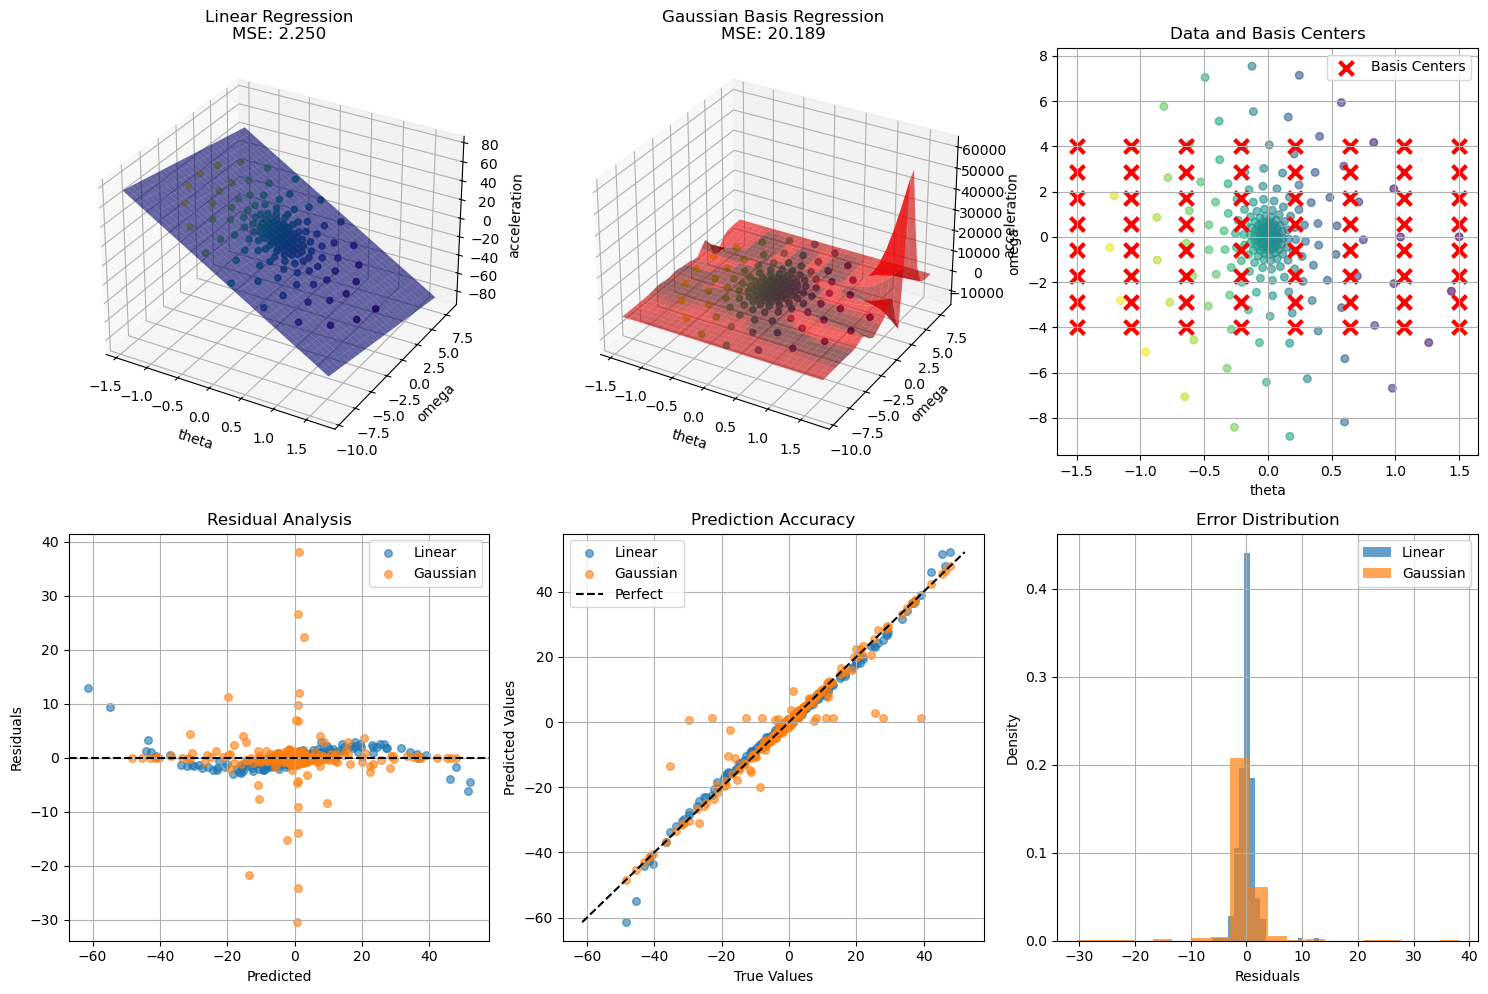

For this nonlinear pendulum data, Gaussian basis regression achieves -797.5% better accuracy.


In [13]:
# Visualize the comparison
plt.figure(figsize=(15, 10))

# Create a fine grid for visualization
theta_grid = np.linspace(X_nl[:,0].min()-0.2, X_nl[:,0].max()+0.2, 30)
omega_grid = np.linspace(X_nl[:,1].min()-0.5, X_nl[:,1].max()+0.5, 30)
Theta_grid, Omega_grid = np.meshgrid(theta_grid, omega_grid)
X_grid = np.c_[Theta_grid.ravel(), Omega_grid.ravel()]

# Predictions on grid
X1_grid = np.c_[np.ones(len(X_grid)), X_grid]
Z_linear = (X1_grid @ w_linear).reshape(Theta_grid.shape)
Z_gaussian = best_model.predict(X_grid).reshape(Theta_grid.shape)

# Plot 1: Linear regression surface
ax1 = plt.subplot(2, 3, 1, projection='3d')
ax1.plot_surface(Theta_grid, Omega_grid, Z_linear, alpha=0.6, color='blue')
ax1.scatter(X_nl[:,0], X_nl[:,1], Y_nl, c=Y_nl, s=20, alpha=0.8)
ax1.set_xlabel('theta')
ax1.set_ylabel('omega')
ax1.set_zlabel('acceleration')
ax1.set_title(f'Linear Regression\nMSE: {mse_linear:.3f}')

# Plot 2: Gaussian basis regression surface
ax2 = plt.subplot(2, 3, 2, projection='3d')
ax2.plot_surface(Theta_grid, Omega_grid, Z_gaussian, alpha=0.6, color='red')
ax2.scatter(X_nl[:,0], X_nl[:,1], Y_nl, c=Y_nl, s=20, alpha=0.8)
ax2.set_xlabel('theta')
ax2.set_ylabel('omega')
ax2.set_zlabel('acceleration')
ax2.set_title(f'Gaussian Basis Regression\nMSE: {best_mse:.3f}')

# Plot 3: Basis function centers
ax3 = plt.subplot(2, 3, 3)
ax3.scatter(X_nl[:,0], X_nl[:,1], c=Y_nl, alpha=0.6, s=30)
ax3.scatter(best_model.centers[:,0], best_model.centers[:,1], 
           c='red', marker='x', s=100, linewidths=3, label='Basis Centers')
ax3.set_xlabel('theta')
ax3.set_ylabel('omega')
ax3.set_title('Data and Basis Centers')
ax3.legend()
ax3.grid(True)

# Plot 4: Residuals comparison
plt.subplot(2, 3, 4)
residuals_linear = Y_nl - Y_pred_linear
residuals_gaussian = Y_nl - best_model.predict(X_nl)
plt.scatter(Y_pred_linear, residuals_linear, alpha=0.6, label='Linear', s=30)
plt.scatter(best_model.predict(X_nl), residuals_gaussian, alpha=0.6, label='Gaussian', s=30)
plt.axhline(y=0, color='k', linestyle='--')
plt.xlabel('Predicted')
plt.ylabel('Residuals')
plt.title('Residual Analysis')
plt.legend()
plt.grid(True)

# Plot 5: Prediction accuracy
plt.subplot(2, 3, 5)
plt.scatter(Y_nl, Y_pred_linear, alpha=0.6, label='Linear', s=30)
plt.scatter(Y_nl, best_model.predict(X_nl), alpha=0.6, label='Gaussian', s=30)
min_val = min(Y_nl.min(), Y_pred_linear.min(), best_model.predict(X_nl).min())
max_val = max(Y_nl.max(), Y_pred_linear.max(), best_model.predict(X_nl).max())
plt.plot([min_val, max_val], [min_val, max_val], 'k--', label='Perfect')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('Prediction Accuracy')
plt.legend()
plt.grid(True)

# Plot 6: Error distribution
plt.subplot(2, 3, 6)
plt.hist(residuals_linear, bins=20, alpha=0.7, label='Linear', density=True)
plt.hist(residuals_gaussian, bins=20, alpha=0.7, label='Gaussian', density=True)
plt.xlabel('Residuals')
plt.ylabel('Density')
plt.title('Error Distribution')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

print(f"For this nonlinear pendulum data, Gaussian basis regression achieves {((mse_linear - best_mse) / mse_linear * 100):.1f}% better accuracy.")

### **3.** Implement an online version of logistic regression.

#### **3.1** Old data and Perceptron class code

In [14]:
# Test by 2D gaussian data
N = 10  # sample size
D = 2
Xp = np.random.randn(N,D) + np.array([3,2])  # positive data
Xn = np.random.randn(N,D)   # negative data
# concatenate positive/negative data
X = np.r_[Xp,Xn]
Yt = np.r_[np.ones(N),-np.ones(N)]  # target
N = 2*N

In [15]:
class Perceptron:
    """Linear perceptron: phi(x)=[1,x]"""
    
    def __init__(self, D=2):
        """Create a new perceptron"""
        # self.w = np.random.randn(D+1)  # output weight
        self.w = np.zeros(D+1)  
        self.vis = False

    def output(self, x):
        """predict an output from input x"""
        u = self.w@np.r_[1,x]
        y = 1 if u>0 else -1
        if self.vis:
            plt.plot(x[0], x[1], "yo" if y>0 else "bo")
        return y

    def learn(self, x, yt, alpha=0.1):
        """learn from (x, yt) pair"""
        y = self.output(x)
        error = y - yt
        if error != 0:
            self.w += alpha*yt*np.r_[1,x]
        if self.vis:
            plt.plot(x[0], x[1], "y*" if yt>0 else "b*")
            self.plot_boundary()
        return error
    
    def plot_boundary(self, u=0, col="k", r=5):
        """plot decision boundary with shift u, range r
        w0 + w1*x + w2*y = u
        y = (u - w0 - w1*x)/w2
        """
        # show weight vector
        plt.plot([0,self.w[1]], [0,self.w[2]], "r", lw=2)
        plt.plot(self.w[1], self.w[2], "r*")  # arrowhead
        # decision boundary
        x = np.linspace(-r, r)
        y = (u-self.w[0] - self.w[1]*x)/self.w[2]
        plt.plot(x, y, col, lw=0.5)
        plt.xlabel("x1"); plt.ylabel("x2"); plt.axis("square"); 
        plt.xlim([-r, r]); plt.ylim([-r, r]);

#### **3.2** Logistic regression with added SGD

In [16]:
class LogisticRegression(Perceptron):
    """Logistic regression"""
    
    def sigmoid(self, u):
        return 1/(1+np.exp(-u))
    
    def output(self, x):
        """output for vector/matrix input x"""
        if x.ndim == 1:  # x is a vector
            self.X = np.r_[1,x]
        else:   # x is a matrix
            self.X = np.c_[np.ones(x.shape[0]),x]
        u = self.X@self.w
        y = self.sigmoid(u)   # sigmoid output
        if self.vis:
            if x.ndim == 1:  # x is a vector
                plt.plot(x[0], x[1], "yo" if y>0.5 else "bo")
            else:   # x is a matrix
                plt.scatter(x[:,0], x[:,1], c=y)
        return y
    
    def sgd_update(self, x, yt, alpha=0.1):
        """Online Stochastic Gradient Descent update with single data point (x, yt)"""
        # Add bias term for single data point
        x_aug = np.r_[1, x] if x.ndim == 1 else np.c_[np.ones(x.shape[0]), x]
        
        # Forward pass
        u = x_aug @ self.w if x.ndim == 1 else x_aug @ self.w
        y = self.sigmoid(u)
        
        # Compute gradient of log-likelihood
        # For logistic regression: gradient = (y - yt) * x
        error = y - yt
        gradient = error * x_aug if x.ndim == 1 else x_aug.T @ error
        
        # SGD update: w = w - alpha * gradient
        self.w -= alpha * gradient
        
        if self.vis:
            if x.ndim == 1:
                plt.plot(x[0], x[1], "y*" if yt > 0.5 else "b*")
                self.plot_boundary(u=0, col="r")
            else:
                plt.scatter(x[:,0], x[:,1], c=yt, marker="*")
                self.plot_boundary(u=0, col="r")
        
        return error
    
    def train_sgd(self, X, Yt, epochs=10, alpha=0.1, shuffle=True):
        """Train using SGD for multiple epochs"""
        N = len(X)
        errors_history = []
        
        for epoch in range(epochs):
            # Shuffle data order for each epoch
            if shuffle:
                indices = np.random.permutation(N)
            else:
                indices = np.arange(N)
            
            epoch_errors = []
            for i in indices:
                error = self.sgd_update(X[i], Yt[i], alpha)
                epoch_errors.append(error**2 if np.isscalar(error) else np.mean(error**2))
            
            avg_error = np.mean(epoch_errors)
            errors_history.append(avg_error)
            
            if (epoch + 1) % 5 == 0 or epoch == 0:
                print(f"Epoch {epoch+1}: Average Error² = {avg_error:.4f}, weights = {self.w}")
        
        return errors_history
    
    def rls(self, x, yt, alpha=0.1):
        """reweighted least square with (x, y) pairs"""
        y = self.output(x)  # also set self.X
        error = y - yt
        R = np.diag(y*(1-y)) # weighting matrix
        self.w -= np.linalg.inv(self.X.T@R@self.X) @ self.X.T@error
        if self.vis:
            plt.scatter(x[:,0], x[:,1], c=yt, marker="*")
            self.plot_boundary(u=1, col="g")
            self.plot_boundary(u=0, col="k")
            self.plot_boundary(u=-1, col="m")
        return error

In [17]:
logreg = LogisticRegression(D=2)
logreg.vis = True
Yb = np.clip(Yt, 0, 1)  # target in [0,1]

 err = 0.25 ; w = [-1.54452465  0.3731691   0.81501852]


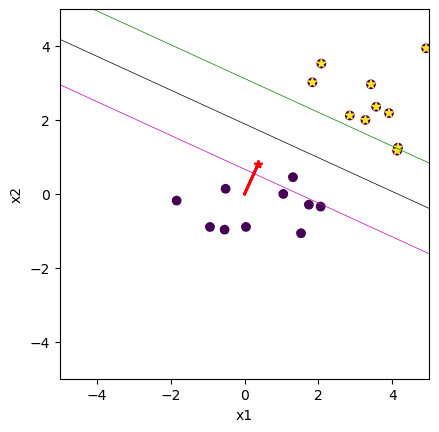

In [18]:
# Repeat for Iterative Reweighted least squares
err = logreg.rls(X, Yb)
print(" err =", np.mean(err**2), "; w =", logreg.w)
plt.show()

#### **3.3** Testing Online SGD vs RLS Methods

In [19]:
# Compare RLS vs SGD methods
print("Comparing Iterative Reweighted Least Squares (RLS) vs Stochastic Gradient Descent (SGD)")
print("="*80)

# Test RLS method first
print("\n1. Testing RLS Method:")
logreg_rls = LogisticRegression(D=2)
logreg_rls.vis = False  # Turn off visualization for cleaner output
Yb = np.clip(Yt, 0, 1)  # target in [0,1]

# Single RLS update
err_rls = logreg_rls.rls(X, Yb)
print(f"RLS - MSE: {np.mean(err_rls**2):.4f}, weights: {logreg_rls.w}")

# Test SGD method
print("\n2. Testing SGD Method:")
logreg_sgd = LogisticRegression(D=2)
logreg_sgd.vis = False

# Train with SGD
errors_sgd = logreg_sgd.train_sgd(X, Yb, epochs=50, alpha=0.1, shuffle=True)
print(f"SGD Final - weights: {logreg_sgd.w}")

print(f"\nFinal comparison:")
print(f"RLS weights: {logreg_rls.w}")
print(f"SGD weights: {logreg_sgd.w}")

Comparing Iterative Reweighted Least Squares (RLS) vs Stochastic Gradient Descent (SGD)

1. Testing RLS Method:
RLS - MSE: 0.2500, weights: [-1.54452465  0.3731691   0.81501852]

2. Testing SGD Method:
Epoch 1: Average Error² = 0.1494, weights = [-0.2774855   0.33955507  0.62330528]
Epoch 5: Average Error² = 0.0368, weights = [-1.1328131   0.42908972  1.40701824]
Epoch 10: Average Error² = 0.0178, weights = [-1.74648297  0.43354862  1.82663642]
Epoch 15: Average Error² = 0.0120, weights = [-2.15040817  0.47810716  2.08800468]
Epoch 20: Average Error² = 0.0084, weights = [-2.45672172  0.5315865   2.28031888]
Epoch 25: Average Error² = 0.0070, weights = [-2.71719112  0.55222503  2.42046971]
Epoch 30: Average Error² = 0.0058, weights = [-2.93341717  0.58553725  2.53938213]
Epoch 35: Average Error² = 0.0047, weights = [-3.11339521  0.641573    2.64618279]
Epoch 40: Average Error² = 0.0039, weights = [-3.28240606  0.66675587  2.73030277]
Epoch 45: Average Error² = 0.0035, weights = [-3.4343

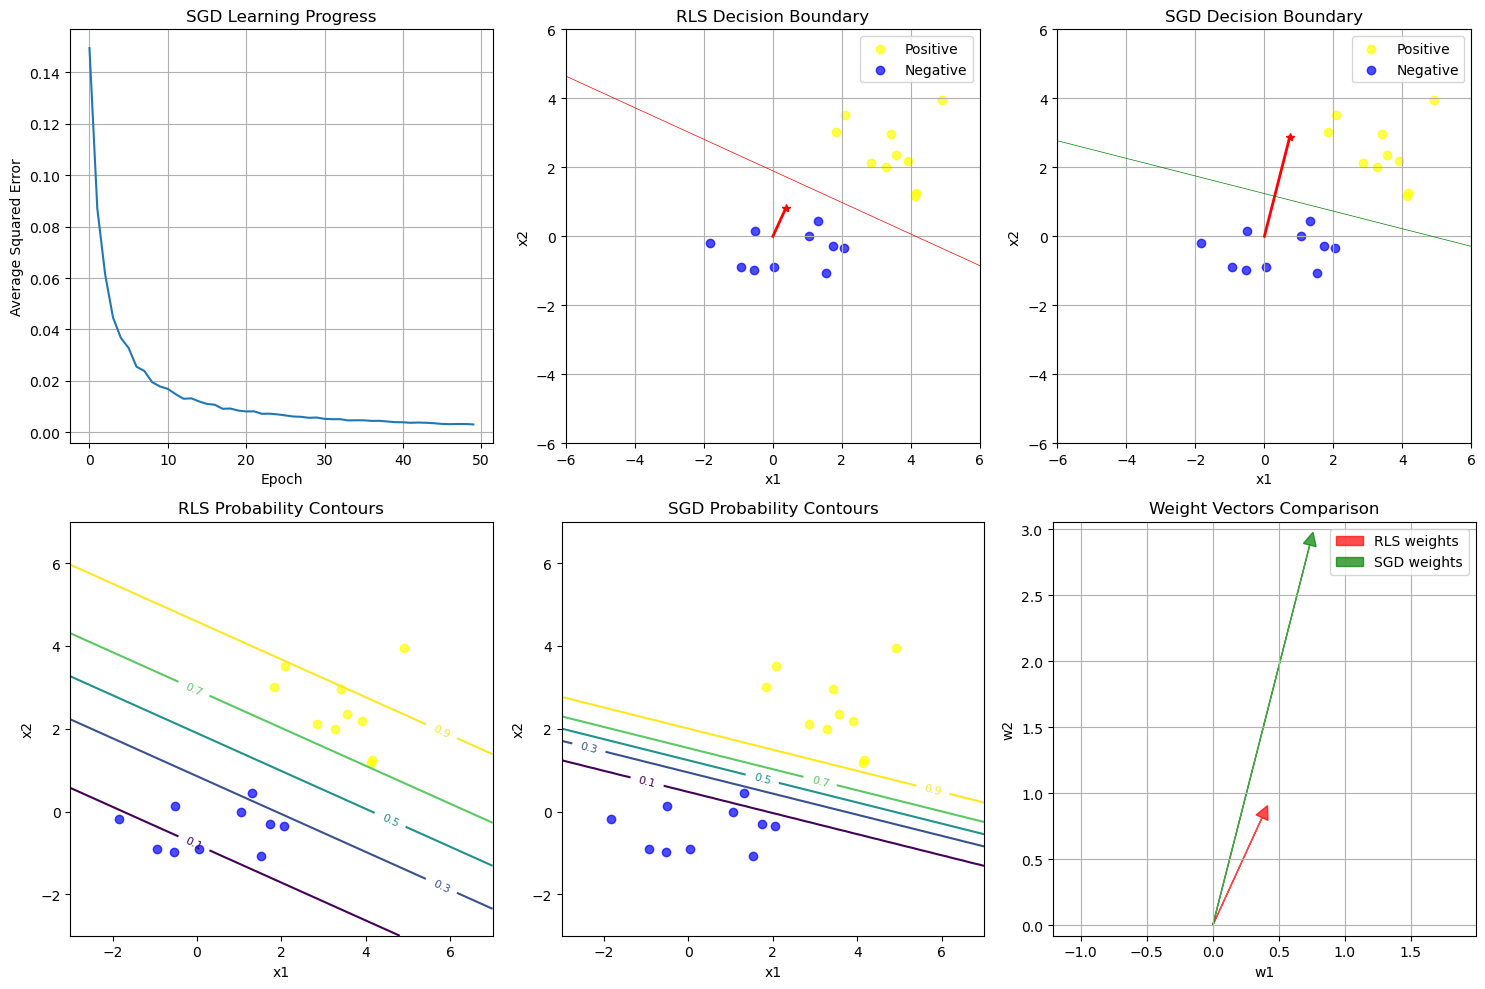

In [20]:
# Visualize the comparison between RLS and SGD
plt.figure(figsize=(15, 10))

# Plot 1: SGD Learning Progress
plt.subplot(2, 3, 1)
plt.plot(errors_sgd)
plt.xlabel('Epoch')
plt.ylabel('Average Squared Error')
plt.title('SGD Learning Progress')
plt.grid(True)

# Plot 2: Data and RLS Decision Boundary
plt.subplot(2, 3, 2)
plt.scatter(Xp[:,0], Xp[:,1], c='yellow', marker='o', label='Positive', alpha=0.7)
plt.scatter(Xn[:,0], Xn[:,1], c='blue', marker='o', label='Negative', alpha=0.7)
logreg_rls.vis = True
logreg_rls.plot_boundary(u=0, col="red", r=6)
plt.title('RLS Decision Boundary')
plt.legend()
plt.grid(True)
logreg_rls.vis = False

# Plot 3: Data and SGD Decision Boundary
plt.subplot(2, 3, 3)
plt.scatter(Xp[:,0], Xp[:,1], c='yellow', marker='o', label='Positive', alpha=0.7)
plt.scatter(Xn[:,0], Xn[:,1], c='blue', marker='o', label='Negative', alpha=0.7)
logreg_sgd.vis = True
logreg_sgd.plot_boundary(u=0, col="green", r=6)
plt.title('SGD Decision Boundary')
plt.legend()
plt.grid(True)
logreg_sgd.vis = False

# Plot 4: Probability contours for RLS
plt.subplot(2, 3, 4)
x1_range = np.linspace(-3, 7, 100)
x2_range = np.linspace(-3, 7, 100)
X1_grid, X2_grid = np.meshgrid(x1_range, x2_range)
X_grid = np.c_[X1_grid.ravel(), X2_grid.ravel()]
prob_rls = logreg_rls.output(X_grid).reshape(X1_grid.shape)
contours = plt.contour(X1_grid, X2_grid, prob_rls, levels=[0.1, 0.3, 0.5, 0.7, 0.9])
plt.clabel(contours, inline=True, fontsize=8)
plt.scatter(Xp[:,0], Xp[:,1], c='yellow', marker='o', alpha=0.7)
plt.scatter(Xn[:,0], Xn[:,1], c='blue', marker='o', alpha=0.7)
plt.title('RLS Probability Contours')
plt.xlabel('x1')
plt.ylabel('x2')

# Plot 5: Probability contours for SGD
plt.subplot(2, 3, 5)
prob_sgd = logreg_sgd.output(X_grid).reshape(X1_grid.shape)
contours = plt.contour(X1_grid, X2_grid, prob_sgd, levels=[0.1, 0.3, 0.5, 0.7, 0.9])
plt.clabel(contours, inline=True, fontsize=8)
plt.scatter(Xp[:,0], Xp[:,1], c='yellow', marker='o', alpha=0.7)
plt.scatter(Xn[:,0], Xn[:,1], c='blue', marker='o', alpha=0.7)
plt.title('SGD Probability Contours')
plt.xlabel('x1')
plt.ylabel('x2')

# Plot 6: Weight evolution comparison
plt.subplot(2, 3, 6)
# Show weight vectors
plt.arrow(0, 0, logreg_rls.w[1], logreg_rls.w[2], head_width=0.1, head_length=0.1, 
          fc='red', ec='red', label='RLS weights', alpha=0.7)
plt.arrow(0, 0, logreg_sgd.w[1], logreg_sgd.w[2], head_width=0.1, head_length=0.1, 
          fc='green', ec='green', label='SGD weights', alpha=0.7)
plt.xlabel('w1')
plt.ylabel('w2')
plt.title('Weight Vectors Comparison')
plt.legend()
plt.grid(True)
plt.axis('equal')

plt.tight_layout()
plt.show()

In [21]:
# Performance evaluation
print("\nPerformance Evaluation:")
print("="*30)

# Compute predictions and accuracy for both methods
y_pred_rls = logreg_rls.output(X)
y_pred_sgd = logreg_sgd.output(X)

# Convert to binary predictions (threshold at 0.5)
y_binary_rls = (y_pred_rls > 0.5).astype(int)
y_binary_sgd = (y_pred_sgd > 0.5).astype(int)
Yb_binary = Yb.astype(int)

# Calculate accuracy
accuracy_rls = np.mean(y_binary_rls == Yb_binary)
accuracy_sgd = np.mean(y_binary_sgd == Yb_binary)

# Calculate log-likelihood (cross-entropy loss)
def log_likelihood(y_pred, y_true):
    # Clip predictions to avoid log(0)
    y_pred = np.clip(y_pred, 1e-15, 1-1e-15)
    return -np.mean(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))

ll_rls = log_likelihood(y_pred_rls, Yb)
ll_sgd = log_likelihood(y_pred_sgd, Yb)

print(f"RLS Method:")
print(f"  Accuracy: {accuracy_rls:.3f}")
print(f"  Cross-entropy loss: {ll_rls:.4f}")
print(f"  Final weights: [{logreg_rls.w[0]:.3f}, {logreg_rls.w[1]:.3f}, {logreg_rls.w[2]:.3f}]")

print(f"\nSGD Method:")
print(f"  Accuracy: {accuracy_sgd:.3f}")
print(f"  Cross-entropy loss: {ll_sgd:.4f}")
print(f"  Final weights: [{logreg_sgd.w[0]:.3f}, {logreg_sgd.w[1]:.3f}, {logreg_sgd.w[2]:.3f}]")


Performance Evaluation:
RLS Method:
  Accuracy: 1.000
  Cross-entropy loss: 0.1910
  Final weights: [-1.545, 0.373, 0.815]

SGD Method:
  Accuracy: 1.000
  Cross-entropy loss: 0.0281
  Final weights: [-3.566, 0.735, 2.880]


#### **3.4** Online learning demonstration


Demonstrating Online Learning:


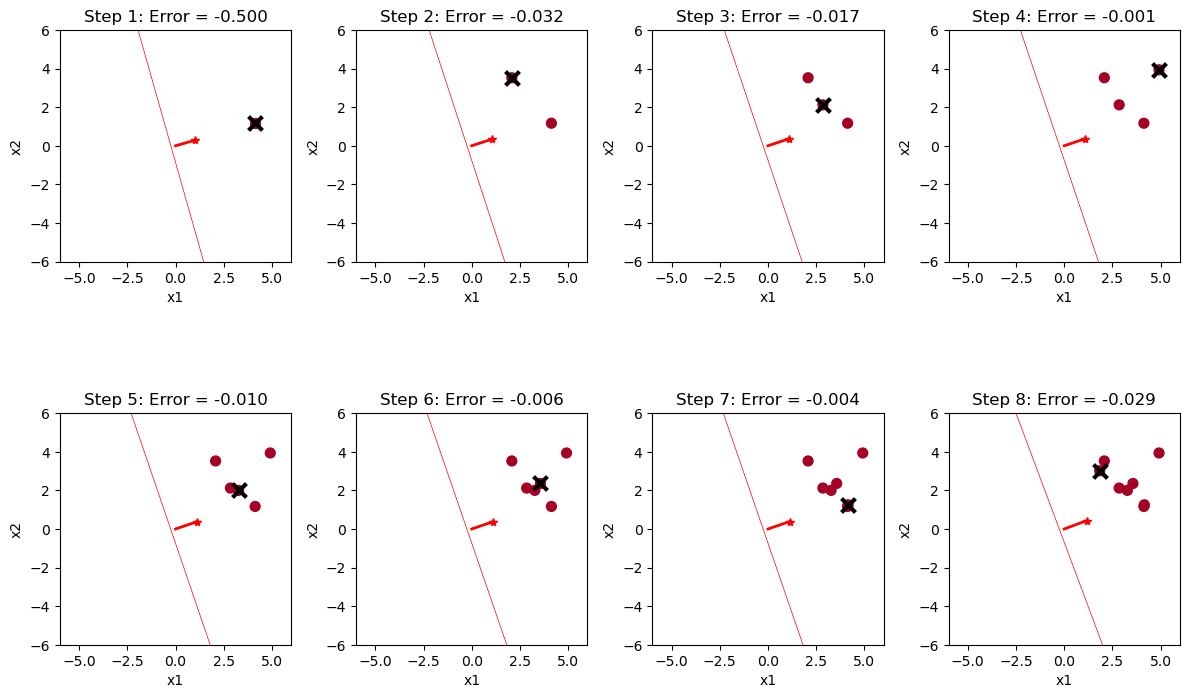


Final online weights: [0.29944646 1.15421785 0.43102405]


In [22]:
# Demonstrate online learning capability
print("\nDemonstrating Online Learning:")
print("="*35)

# Create a new logistic regression model for online demo
online_logreg = LogisticRegression(D=2)

# Simulate online learning scenario
plt.figure(figsize=(12, 8))

# Process data points one by one and show evolution
for i in range(min(8, len(X))):
    plt.subplot(2, 4, i+1)

    error = online_logreg.sgd_update(X[i], Yb[i], alpha=0.5)                        # Update with current data point
    plt.scatter(X[:i+1,0], X[:i+1,1], c=Yb[:i+1], cmap='RdYlBu', marker='o', s=50)  # Plot all data points seen so far
    plt.scatter(X[i,0], X[i,1], c='black', marker='x', s=100, linewidths=3)         # Highlight current point
    
    # Plot decision boundary
    online_logreg.vis = True
    online_logreg.plot_boundary(u=0, col="red", r=6)
    online_logreg.vis = False
    
    plt.title(f'Step {i+1}: Error = {error:.3f}')
    plt.xlabel('x1')
    plt.ylabel('x2')

plt.tight_layout()
plt.show()

print(f"\nFinal online weights: {online_logreg.w}")